In [128]:
from pathlib import Path
from multiprocessing import Pool
import logging

import click
import pandas as pd
import numpy as np
import SimpleITK as sitk
import nibabel as nib
import tifffile as tif

## Image folder locations

In [114]:
input_image_folder = "../../datasets/ADDA/resampled/images/"
input_label_folder = "../../datasets/ADDA/resampled/labels/"
output_image_folder = "../dataset/images_resampled/"
output_label_folder = "../dataset/labels_resampled/"

In [115]:
input_image_folder = Path(input_image_folder).resolve()
input_label_folder = Path(input_label_folder).resolve()
output_image_folder = Path(output_image_folder).resolve()
output_label_folder = Path(output_label_folder).resolve()

In [121]:
# get names of all images (patients)
patient_list = [
        f.name.split("__")[0] for f in input_image_folder.rglob("*_CT*")
    ]

if len(patient_list) == 0:
    raise ValueError("No patient found in the input folder")

len(patient_list)

270

## Extract number of positives for each patient

In [216]:
# empty dictionary to store num of positive slices
num_positives = []
images_dict = dict()

for i, p in enumerate(patient_list):
    # if i==5:
    #     break
    print(i, p)
    img = nib.load(str([f for f in input_label_folder.rglob(p + "*")][0]))
    # Get the NIfTI image data as a NumPy array
    img_data = img.get_fdata()
    img_data.shape
    # Find non-black slices
    non_black_slices = []
    for i in range(img_data.shape[-1]):
        slice_data = img_data[..., i]
        if np.any(slice_data > 0):  # Change the condition as needed
            non_black_slices.append(i)
    num_positives.append(len(non_black_slices))
    print(len(non_black_slices))
    # add info to images_dict
    images_dict[p] = non_black_slices
    
    

0 MDA-111
40
1 MDA-126
59
2 MDA-005
131
3 MDA-032
33
4 MDA-173
42
5 MDA-144
52
6 MDA-067
55
7 MDA-050
81
8 MDA-098
68
9 CHUP-028
36
10 MDA-019
98
11 MDA-158
65
12 CHUP-056
44
13 MDA-190
102
14 CHUP-061
63
15 MDA-084
56
16 CHUP-034
24
17 CHUP-003
66
18 CHUP-012
54
19 CHUP-025
73
20 MDA-095
59
21 CHUP-070
77
22 CHUP-047
68
23 MDA-181
56
24 MDA-149
124
25 CHUP-039
63
26 MDA-089
49
27 MDA-041
75
28 MDA-076
98
29 MDA-155
49
30 MDA-162
95
31 MDA-023
56
32 MDA-014
39
33 MDA-137
62
34 MDA-100
117
35 MDA-058
69
36 MDA-119
47
37 CHUP-020
41
38 CHUP-017
76
39 CHUP-042
63
40 MDA-184
62
41 CHUP-075
95
42 MDA-090
124
43 MDA-167
89
44 MDA-150
137
45 MDA-073
59
46 MDA-044
111
47 MDA-105
111
48 MDA-132
39
49 MDA-011
27
50 MDA-026
95
51 CHUP-069
54
52 MDA-198
69
53 MDA-189
79
54 MDA-037
94
55 MDA-123
33
56 MDA-114
69
57 MDA-055
36
58 MDA-062
62
59 MDA-141
78
60 MDA-176
124
61 MDA-081
13
62 CHUP-064
52
63 CHUP-053
55
64 MDA-195
57
65 CHUP-006
42
66 MDA-108
45
67 MDA-049
95
68 MDA-138
76
69 MDA-079
124
70

## Calculate average number of positive slices in dataset

In [217]:

count=0
for k,v in images_dict.items():
    print(k, len(v))
    count+=len(v)
count/len(images_dict.keys())
    

MDA-111 40
MDA-126 59
MDA-005 131
MDA-032 33
MDA-173 42
MDA-144 52
MDA-067 55
MDA-050 81
MDA-098 68
CHUP-028 36
MDA-019 98
MDA-158 65
CHUP-056 44
MDA-190 102
CHUP-061 63
MDA-084 56
CHUP-034 24
CHUP-003 66
CHUP-012 54
CHUP-025 73
MDA-095 59
CHUP-070 77
CHUP-047 68
MDA-181 56
MDA-149 124
CHUP-039 63
MDA-089 49
MDA-041 75
MDA-076 98
MDA-155 49
MDA-162 95
MDA-023 56
MDA-014 39
MDA-137 62
MDA-100 117
MDA-058 69
MDA-119 47
CHUP-020 41
CHUP-017 76
CHUP-042 63
MDA-184 62
CHUP-075 95
MDA-090 124
MDA-167 89
MDA-150 137
MDA-073 59
MDA-044 111
MDA-105 111
MDA-132 39
MDA-011 27
MDA-026 95
CHUP-069 54
MDA-198 69
MDA-189 79
MDA-037 94
MDA-123 33
MDA-114 69
MDA-055 36
MDA-062 62
MDA-141 78
MDA-176 124
MDA-081 13
CHUP-064 52
CHUP-053 55
MDA-195 57
CHUP-006 42
MDA-108 45
MDA-049 95
MDA-138 76
MDA-079 124
CHUP-063 79
MDA-192 46
CHUP-054 35
MDA-086 62
CHUP-001 35
CHUP-036 43
MDA-124 26
MDA-113 51
MDA-030 50
MDA-007 55
MDA-146 103
MDA-171 52
MDA-052 39
MDA-065 66
CHUP-048 48
CHUP-059 46
MDA-074 47
MDA-043 

63.3962962962963

In [218]:
# images_dict['MDA-079']

In [220]:
# len(images_dict['MDA-017'])

121

## Load and save images as Tiff stack

In [231]:
def apply_window(img, width=500, center=40):
    # np.interp(a, (a.min(), a.max()), (-1, +1))

    # convert below window to black
    img[img<(center-(width/2))]=center-(width/2)
    # convert above window to white
    img[img>(center+(width/2))]=center+(width/2)

    # normalize image
    img_scaled = np.interp(img, (img.min(), img.max()), (0, +1))
    # print(img_scaled.shape)
    # print(np.min(img_scaled), np.max(img_scaled))
    return img

In [273]:
i = 0
n = 100
for k,v in images_dict.items():
    # if k != 'CHUP-058':
    #     # print('skipping', k)
    #     continue

    print(f'{i} - working on {k}')
    
    # select one image 
    img_name = k
    slices_to_save = v
    print(f'{k} has {len(v)} positive slices')
    # load the image
    ct = nib.load(str(input_image_folder)+f'/{k}__CT.nii.gz')
    ct = ct.get_fdata()

    pt = nib.load(str(input_image_folder)+f'/{k}__PT.nii.gz')
    pt = pt.get_fdata()

    msk = nib.load(str(input_label_folder)+f'/{k}.nii.gz')
    msk = msk.get_fdata()

    print(ct.shape, pt.shape, msk.shape)
    print(f'positive slices are between {min(v)} and {max(v)} total is {len(v)}')

    orig_first = min(v)
    orig_last = max(v)

    median = v[len(v) // 2]
    print(orig_first, orig_last, median)
    print('saving from ',  median-(n//2), 'to ',median+(n//2))

    # ensure slices are within bounds
    max_idx = ct.shape[2]
    min_idx = 0

    # if theres not enough slices
    if (median+(n//2) > max_idx) or (median-(n//2) < min_idx):
        
        final_ct = apply_window(ct[:,:,median-(n//2)-3:median+(n//2)])
        final_pt = pt[:,:,median-(n//2)-3:median+(n//2)]
        final_mask = msk[:,:,median-(n//2)-3:median+(n//2)]
        # just keep gtv
        final_mask = (final_mask == 1)
        
    else:
    
        final_ct = apply_window(ct[:,:,median-(n//2):median+(n//2)])
        final_pt = pt[:,:,median-(n//2):median+(n//2)]
        final_mask = msk[:,:,median-(n//2):median+(n//2)]
        # just keep gtv
        final_mask = (final_mask == 1)
    
    print(final_ct.shape, final_pt.shape, final_mask.shape, '\n')
    

    with open('./logs/success_tiff.txt', 'a') as f:
            f.write(f'{i} --- {k} has {len(v)} positive slices\n')
            f.write(f'{i} --- ct {ct.shape}, pt {pt.shape}, mask {msk.shape}\n')
            f.write(f'{i} --- positive slices are between {min(v)} and {max(v)} total is {len(v)}\n')
            f.write(f'{i} --- saving from {median-(n//2)} to {median+(n//2)}\n\n')

    if (median+(n//2) > max_idx) or (median-(n//2) < min_idx):
        with open('./logs/fail_tiff.txt', 'a') as f:
            f.write(f'{i} --- {k} has {len(v)} positive slices\n')
            f.write(f'{i} --- ct {ct.shape}, pt {pt.shape}, mask {msk.shape}\n')
            f.write(f'{i} --- positive slices are between {min(v)} and {max(v)} total is {len(v)}\n')
            f.write(f'{i} --- saving from {median-(n//2)} to {median+(n//2)}\n\n')
        print('failed....')
        continue

    # Open a TiffWriter object
    tif.imwrite(f'../dataset/tiff/images/{img_name}__CT.tiff', final_ct)
    tif.imwrite(f'../dataset/tiff/images/{img_name}__PT.tiff', final_pt)
    tif.imwrite(f'../dataset/tiff/labels/{img_name}.tiff', final_mask)
    
    # break
    # if i==10:
    #     break
    i+=1

0 - working on MDA-111
MDA-111 has 40 positive slices
(500, 500, 975) (500, 500, 975) (500, 500, 975)
positive slices are between 813 and 852 total is 40
813 852 833
saving from  783 to  883
(500, 500, 100) (500, 500, 100) (500, 500, 100) 

1 - working on MDA-126
MDA-126 has 59 positive slices
(500, 500, 415) (500, 500, 415) (500, 500, 415)
positive slices are between 156 and 214 total is 59
156 214 185
saving from  135 to  235
(500, 500, 100) (500, 500, 100) (500, 500, 100) 

2 - working on MDA-005
MDA-005 has 131 positive slices
(500, 500, 873) (500, 500, 873) (500, 500, 873)
positive slices are between 574 and 704 total is 131
574 704 639
saving from  589 to  689
(500, 500, 100) (500, 500, 100) (500, 500, 100) 

3 - working on MDA-032
MDA-032 has 33 positive slices
(498, 498, 873) (498, 498, 873) (498, 498, 873)
positive slices are between 646 and 678 total is 33
646 678 662
saving from  612 to  712
(498, 498, 100) (498, 498, 100) (498, 498, 100) 

4 - working on MDA-173
MDA-173 has

## Preview output

(500, 500, 100) (500, 500, 100) (500, 500, 100)


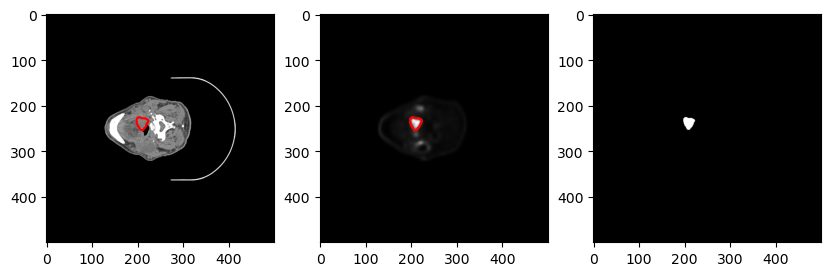

In [271]:
import tifffile as tif
import matplotlib.pyplot as plt

# Open the TIFF file
ct = tif.imread('../dataset/tiff/images/CHUP-058__CT.tiff')
pet = tif.imread('../dataset/tiff/images/CHUP-058__PT.tiff')
mask = tif.imread('../dataset/tiff/labels/CHUP-058.tiff')

print(ct.shape, pet.shape, mask.shape)
slice = 50
# Display the image
fig, ax = plt.subplots(ncols=3, figsize=(10,10))
ax[0].imshow(ct[:,:,slice], cmap='gray')
ax[0].contour(mask[:,:,slice], colors='red')
ax[1].imshow(pet[:,:,slice], cmap='gray')
ax[1].contour(mask[:,:,slice], colors='red')
ax[2].imshow(mask[:,:,slice], cmap='gray')
plt.show()


# Resampling

In [57]:
resampler = sitk.ResampleImageFilter()
resampler.SetOutputDirection([1, 0, 0, 0, 1, 0, 0, 0, 1])
resampler.SetOutputSpacing(resampling)

In [58]:
def get_bouding_boxes(ct, pt):
    """
    Get the bounding boxes of the CT and PT images.
    This works since all images have the same direction
    """

    ct_origin = np.array(ct.GetOrigin())
    pt_origin = np.array(pt.GetOrigin())

    ct_position_max = ct_origin + np.array(ct.GetSize()) * np.array(
        ct.GetSpacing())
    pt_position_max = pt_origin + np.array(pt.GetSize()) * np.array(
        pt.GetSpacing())
    return np.concatenate(
        [
            np.maximum(ct_origin, pt_origin),
            np.minimum(ct_position_max, pt_position_max),
        ],
        axis=0,
    )

In [67]:
def resample_one_patient(p):
    ct = sitk.ReadImage(
        str([f for f in input_image_folder.rglob(p + "__CT*")][0]))
    pt = sitk.ReadImage(
        str([f for f in input_image_folder.rglob(p + "__PT*")][0]))
    labels = [(sitk.ReadImage(str(f)), f.name)
              for f in input_label_folder.glob(p + "*")]
    bb = get_bouding_boxes(ct, pt)
    print(ct.GetSize())
    print(bb[3:]) 
    print(bb[:3],'\n')
    size = np.round((bb[3:] - bb[:3]) / resampling).astype(int)
    print(bb)
    return size
    # resampler.SetOutputOrigin(bb[:3])
    # resampler.SetSize([int(k) for k in size])  # sitk is so stupid
    # resampler.SetInterpolator(sitk.sitkBSpline)
    # ct = resampler.Execute(ct)
    # pt = resampler.Execute(pt)
    # sitk.WriteImage(ct, str((output_image_folder / (p + "__CT.nii.gz"))))
    # sitk.WriteImage(pt, str((output_image_folder / (p + "__PT.nii.gz"))))
    # resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    # for label, name in labels:
    #     label = resampler.Execute(label)
    #     sitk.WriteImage(label, str((output_label_folder / name)))

In [83]:
resampling = (1,1,1)

In [84]:
patient_list[3]

'MDA-117'

In [85]:
x = resample_one_patient(patient_list[3])
# for p in patient_list:
#         resample_one_patient(p)

(512, 512, 335)
[249.99975586 249.99975586 -20.98009777]
[ -250.          -250.         -1116.42993164] 

[ -250.          -250.         -1116.42993164   249.99975586
   249.99975586   -20.98009777]


In [86]:
x

array([ 500,  500, 1095])